In [1]:
!pip install pyarrow

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
# Vectorization
dv = DictVectorizer()

import pickle

In [17]:
## all preprocessing
def read_data(filename):
    
    df1 = pd.read_parquet(filename)

    # duration = drop off time - pick up time
    df1.loc[:,"duration"] = df1.loc[:,"dropOff_datetime"] - df1.loc[:,"pickup_datetime"]

    # reset index
    df1 = df1.reset_index(drop=True)

    # convert duration to seconds and then minutes
    df1["duration"] = df1["duration"].apply(lambda x:x.total_seconds()/60)

    # filter the dataset based on duration (in mins)
    df1 = df1[(df1["duration"]>0)&(df1["duration"]<=60)]

    # use the pick up location, drop off location and trip distance to predict the ride duration
    clean_df = df1[["PUlocationID", "DOlocationID", "duration"]]
    
    return clean_df

In [18]:
train_df = read_data("./data/fhv_tripdata_2021-01.parquet")
train_df.shape

(1124850, 3)

In [19]:
test_df = read_data("./data/fhv_tripdata_2021-02.parquet")
test_df.shape

(1001841, 3)

In [24]:
print(train_df["DOlocationID"].nunique())
print(test_df["DOlocationID"].nunique())

263


264

In [26]:
train_df["DOlocationID"].value_counts()

-1.0     148890
76.0      26513
217.0     19596
265.0     18805
17.0      18626
          ...  
27.0         18
30.0         13
2.0          11
105.0         4
199.0         1
Name: DOlocationID, Length: 263, dtype: int64

In [31]:
test_df["DOlocationID"].dtype

dtype('O')

In [32]:
# drop a unique value to match the number of unique values in train. "264.0" just two samples
test = test_df[test_df["DOlocationID"]!="264.0"]
test["DOlocationID"].nunique()

263

In [20]:
# data transformation
def transform_data(df1, categorical):
    
    df1["PUlocationID"] = df1["PUlocationID"].fillna(-1)
    df1["DOlocationID"] = df1["DOlocationID"].fillna(-1)
    
    df1[categorical] = df1[categorical].astype(str)
    
    X = df1[categorical]
    X = df1[categorical].to_dict(orient="records")
    X = dv.fit_transform(X) # DictVectorizer
    y = df1["duration"]
    
    return X, y

In [33]:
categorical = ["PUlocationID", "DOlocationID"]
X_train, y_train = transform_data(train_df, categorical)
X_test, y_test = transform_data(test, categorical)

/tmp/ipykernel_3210/4209974648.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["PUlocationID"] = df1["PUlocationID"].fillna(-1)
/tmp/ipykernel_3210/4209974648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["DOlocationID"] = df1["DOlocationID"].fillna(-1)
/tmp/ipykernel_3210/4209974648.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [34]:
# model building
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### Model Testing

In [35]:
# predicting on same train data to see how the model fits
y_train_pred = lr.predict(X_train)

/root/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


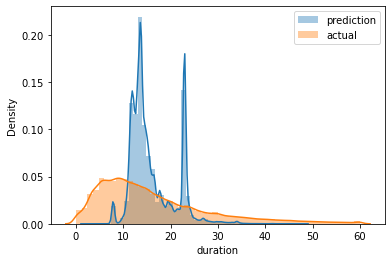

In [36]:
sns.distplot(y_train_pred, label="prediction")
sns.distplot(y_train, label="actual")
plt.legend()
plt.show()

In [40]:
# performance on train
mean_squared_error(y_train_pred, y_train, squared=False)

10.629704061672262

In [38]:
# predicting on test data to see how the model performs
y_test_pred = lr.predict(X_test)

In [39]:
# performance on test
mean_squared_error(y_test_pred, y_test, squared=False)

12.028745641647713